## Filtering drug response curves

Tasks:
    1. propose and check filtering criteria
    2. visualise filtering results
    3. Generate figures for the final report and presentation
    4. Label data according to filtration stages

From first EDA there are many drug response curve that do not have expected sigmoid shape

**Proposed function for Filtering_curves**
(df, response_columns, filtering_scenario = [1,2,3], first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2], tolerance=0.05, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

filtering_scenario = [1,2,3]
1. Ensure that all the response are less than 1

2. Ensure that first and last points form a plateu
the minimal number of points are specified in the function arguments
by default, two points for both lpateus are considered
tolerance =0.05 values to ensure the points form a plateu
first_columns_to_compare = [1, 2]  - first two columns for plateu
last_columns_to_compare = [-1, -2] - last two columns for plateu

3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit

Second Proposed function for Filtering_curves (df, response_columns, filtering_scenario = [1,2,3], first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2], tolerance=0.05, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

filtering_scenario = [1,2,3]

Ensure that all the response are less than 1

Ensure that first and last points form a plateu the minimal number of points are specified in the function arguments by default, two points for both lpateus are considered tolerance =0.05 values to ensure the points form a plateu first_columns_to_compare = [1, 2] - first two columns for plateu last_columns_to_compare = [-1, -2] - last two columns for plateu

Specify location of the plateus - first_points_lower_limit and last_points_upper_limit

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

In [2]:
def ShowResponseCurves(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[]):
 
                
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) ==0:
        indexes =df.index[start_index : start_index+n_plots]

    for i, ind in list(enumerate(indexes)):
        x = df.loc[ind, x_columns]
        y = df.loc[ind, y_columns]
                
        ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
        ax.scatter(x,y)
        ax.set_title(str(df.loc[ind, "DRUG_ID"])+"_"+str(df.loc[ind, "COSMIC_ID"]))
        ax.set_xlabel("Scaled dosage")
        ax.set_ylabel("Normalised response")
        

def FilteringCurves(df, response_columns, filtering_scenario = [1,2,3], 
                     first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2],
                     tolerance=0.05, 
                     first_points_lower_limit = 0.8, 
                     last_points_upper_limit = 0.4,
                      middle_points_limit = 0.1):
    """
    filtering_scenario = [1,2,3]
    1. Ensure that all the response are less than 1
    
    2. Ensure that first and last points form plateus
    the minimal number of points are specified in the function arguments
    by default, two points for both lpateus are considered
    tolerance =0.05 values to ensure the points form a plateu
    first_columns_to_compare = [1, 2]  - first two columns for plateu
    last_columns_to_compare = [-1, -2] - last two columns for plateu
    
    3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit
    
    4. Cutting off ambiqueos data:
    Among all "middle" datapoints a subsequent point should not be higher than antecedent by 0.2
    """
    df = df.copy()
    print("Original dataset:", df.shape)
    
    for i in filtering_scenario:
        if i ==1:
            #1st filtering
            index_row_more_than_1 = []
            for col in response_columns:
                if sum(df[col]>1)>0:
                    index_row_more_than_1.extend(df[df[col]>1].index)
        
            index_row_less_than_1 = set(df.index) - set(index_row_more_than_1)
            df = df.loc[index_row_less_than_1, :].copy()
            print("1st filtration (Ensure that all the response are less than 1): Filtered dataset:", df.shape)
        
        elif i== 2: 
            #2nd filtering
            df["dif_first"]=abs(df[response_columns[first_columns_to_compare[0]-1]]\
                                     - df[response_columns[first_columns_to_compare[1]-1]])
            df["dif_last"]=abs(df[response_columns[last_columns_to_compare[0]]] \
                                        - df[response_columns[last_columns_to_compare[1]]])

            df = df[(df["dif_first"]<= tolerance)
                           &(df["dif_last"]<= tolerance)]
    
            print("2d filtration (Ensure that first and last points form plateus): Filtered dataset:", df.shape)
        elif i== 3: 
                #3d filtering
                df = df[(df[response_columns[1]]>first_points_lower_limit) 
                         & (df[response_columns[-1]]<last_points_upper_limit)]
                print("3d stage filtration (Specified location of the plateus): Filtered dataset:", df.shape)
        
        elif i==4:
            for j in range(1, len(response_columns)-2): # two first and two last are already assessed
                df = df[(df[response_columns[j]] - df[response_columns[j+1]])>middle_points_limit]
            
            print("4th stage filtration (Cut off high ancedent points): Filtered dataset:", df.shape)
            
        else:
            print("Unknown filtration scenario")
    
    return df
        

### Original data

In [3]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CLL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
#del df
drug_curves.shape

/home/marina/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (28,30,31,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(225384, 44)

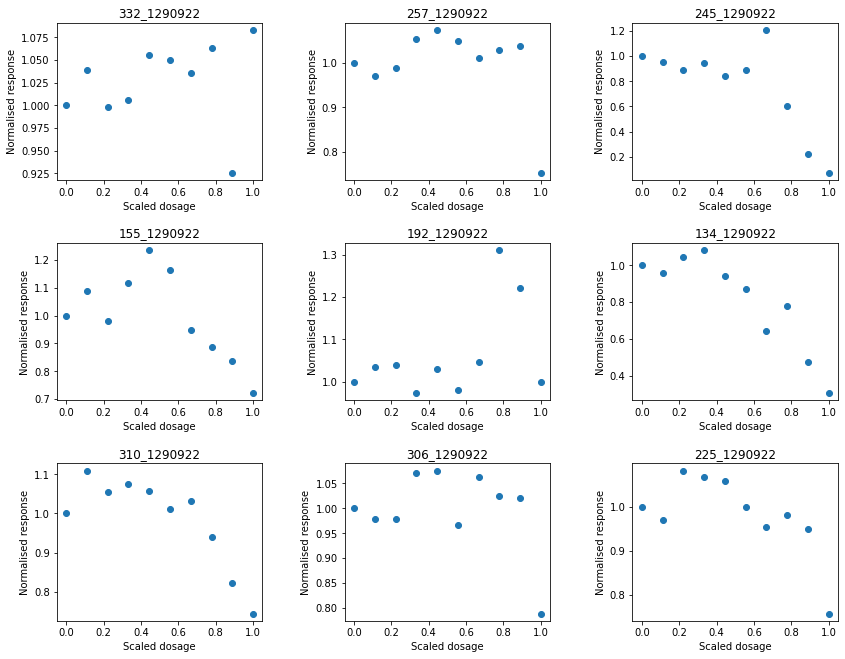

In [4]:
ShowResponseCurves(drug_curves, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=drug_curves.index[:9])

In [5]:
drug_curves.head()

Unnamed: 0 CELL_LINE_NAME  COSMIC_ID  DRUG_ID DRUGID_COSMICID  \
0           0         HDQ-P1    1290922      332     332_1290922   
1           1         HDQ-P1    1290922      257     257_1290922   
2           2         HDQ-P1    1290922      245     245_1290922   
3           3         HDQ-P1    1290922      155     155_1290922   
4           4         HDQ-P1    1290922      192     192_1290922   

   FOLD_DILUTION  MAX_CONC  fd_num_0  fd_num_1  fd_num_2  ...  \
0              2    10.240         0  0.111111  0.222222  ...   
1              2    10.240         0  0.111111  0.222222  ...   
2              2    40.000         0  0.111111  0.222222  ...   
3              2     0.512         0  0.111111  0.222222  ...   
4              2    16.000         0  0.111111  0.222222  ...   

   per_slope_change_7   slope_0   slope_1   slope_2   slope_3   slope_4  \
0            -2.14694  0.354085 -0.371905  0.069255  0.450075 -0.049503   
1            -30.3283 -0.275239  0.163481  0.586129  0.180903 -0.221430   
2           -0.618543 -0.394857 -0.615137  0.485215 -0.923687  0.466260   
3             1.14591  0.791510 -0.964611  1.238764  1.046952 -0.652559   
4             1.53355  0.317413  0.044115 -0.604783  0.510820 -0.431190   

    slope_5   slope_6   slope_7   slope_8  
0 -0.131784  0.246947 -1.239447  1.421566  
1 -0.349017  0.157822  0.087103 -2.554585  
2  2.837371 -5.409070 -3.468825 -1.323207  
3 -1.921061 -0.541266 -0.480877 -1.031916  
4  0.575779  2.380415 -0.793585 -2.010587  

[5 rows x 44 columns]

### Figure for the report - Example of Invalid raw data

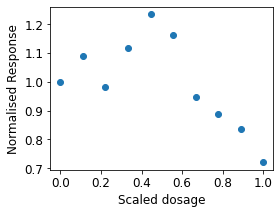

In [6]:
plt.figure(figsize=(4,3))
ind = drug_curves.index[3]
x = drug_curves.loc[ind, conc_columns]
y = drug_curves.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=12)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised Response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt0.png", bbox_inches='tight', dpi=360)
 #plt.savefig(_FOLDER_2+"filt0.eps", format='eps', dpi=1000)

### Filtered data

**Filtering_curves**
(df, response_columns, filtering_scenario = [1,2,3], first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2], tolerance=0.05, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

filtering_scenario = [1,2,3]
1. Ensure that all the response are less than 1

2. Ensure that first and last points form a plateu
the minimal number of points are specified in the function arguments
by default, two points for both lpateus are considered
tolerance =0.05 values to ensure the points form a plateu
first_columns_to_compare = [1, 2]  - first two columns for plateu
last_columns_to_compare = [-1, -2] - last two columns for plateu

3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit

### Filtering scenario 1

In [7]:
df = FilteringCurves(drug_curves, filtering_scenario=[1], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)


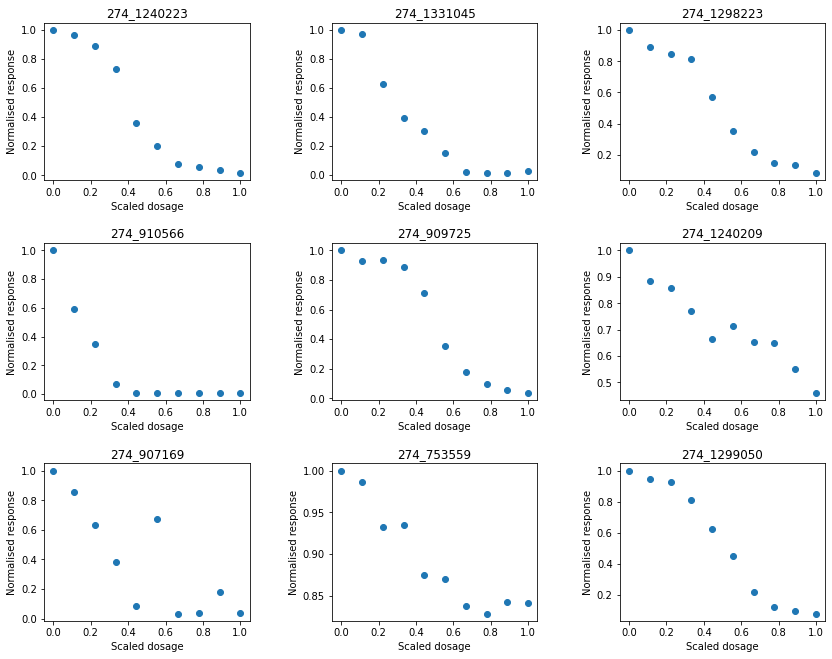

In [8]:
df2 = df[df["DRUG_ID"]==274]

ShowResponseCurves(drug_curves, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df2.index[:9])

### Figure for the report - Results of filtraion: Sigmoid and Linear trends

### Example of Valid Curves

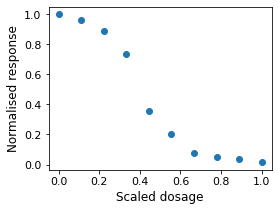

In [9]:
plt.figure(figsize=(4,3))
# Belinostat
ind = df[(df["DRUG_ID"]==274) &(df["COSMIC_ID"]==1240223)].index
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=11)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt_Fig1a.png", bbox_inches='tight', dpi=360)

### Example of Not good response (No plateus)

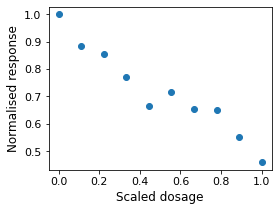

In [10]:
plt.figure(figsize=(4,3))
# Belinostat
ind = df[(df["DRUG_ID"]==274) &(df["COSMIC_ID"]==1240209)].index
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=11)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt_Fig1b.png", bbox_inches='tight', dpi=360)

### Filtering scenario 1+2 

In [11]:
df = FilteringCurves(drug_curves, filtering_scenario=[1, 2], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)


### Figures for the report - Invalid data left after filtration

Presence of "plateus, when difference between points is in the specified range, but min response is >0.8

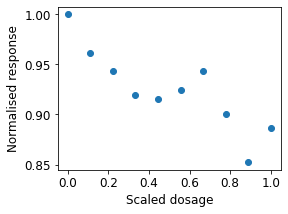

In [12]:
plt.figure(figsize=(4,3))
ind = df[(df["DRUG_ID"]==171) &(df["COSMIC_ID"]== 753551)].index
ind = df.index[10]
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=12)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt2_1.png", bbox_inches='tight', dpi=360)

## Necessity for additional constrains

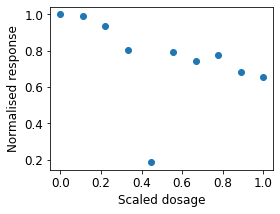

In [13]:
plt.figure(figsize=(4,3))
ind = df[(df["DRUG_ID"]==190) &(df["COSMIC_ID"]==908128)].index
# ind = df.index[1]
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=12)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
# plt.savefig(_FOLDER_2+"filt2_2.png", bbox_inches='tight')

#### Solved by 3 criteria of filtration (Specified location of the plateus)

### Ambiguous samples found from further fitting

In [14]:
def show_one(df, drug_id, cosmic_id, print_title = True, save_name=None):
    plt.figure(figsize=(4,3))
    ind = df[(df["DRUG_ID"]==drug_id) &(df["COSMIC_ID"]==cosmic_id)].index

    x = df.loc[ind, conc_columns]
    y = df.loc[ind, response_norm]
    plt.scatter(x, y)
    plt.tick_params(labelsize=12)
    plt.xlabel("Scaled dosage", fontsize=12)
    plt.ylabel("Normalised response", fontsize=12)
    if print_title:
        plt.title(drug_names[drug_id]+"_"+str(cosmic_id));
    if save_name:
        plt.savefig(_FOLDER_2+save_name+".png", bbox_inches='tight')

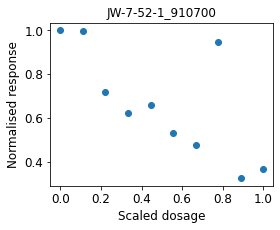

In [15]:
drug_id = 83
cosmic_id = 910700
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

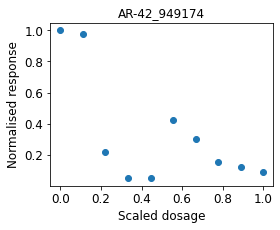

In [16]:
drug_id = 272
cosmic_id = 949174
# show_one(df,drug_id, cosmic_id, print_title= False, save_name=str(drug_id)+"_"+str(cosmic_id))
show_one(df,drug_id, cosmic_id, print_title= True)

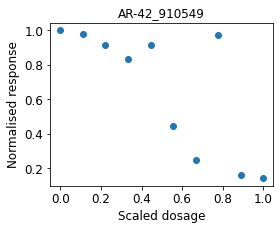

In [17]:
drug_id = 272
cosmic_id = 910549
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

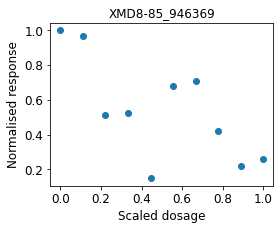

In [18]:
drug_id = 106
cosmic_id = 946369
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

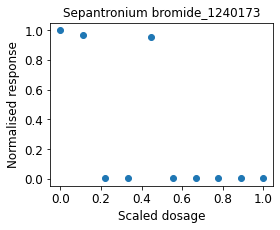

In [19]:
drug_id = 268
cosmic_id = 1240173
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

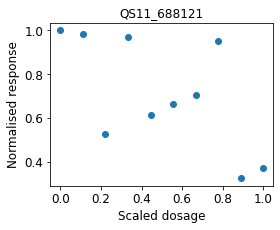

In [20]:
drug_id = 151
cosmic_id = 688121
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

## Possible 4-th filtering criteria:

There are 10 points in total
<br>Two first points and last two points are assumed to form a plateu, 
and we a filtering restriction for them to be in a secified range.

So our new constrain might be: for the middle points, a subsequent point should not be higher than antecedent by 0.2
And we want to visualise drug profiles which were filtered out by this criteria

In [21]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)
#df.to_csv(_FOLDER_3+"sigmoid_01.csv")

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2600, 46)


In [22]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.2)
#df.to_csv(_FOLDER_3+"sigmoid_02.csv")

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2719, 46)


In [23]:
j=3
response_columns = response_norm
middle_points_limit = -0.1
df_11 = df[(df[response_columns[j]] - df[response_columns[j+1]])<middle_points_limit]
middle_points_limit = -0.2
df_22 = df[(df[response_columns[j]] - df[response_columns[j+1]])<middle_points_limit]
print(df_11.shape)
df_11.head()

(22, 46)


Unnamed: 0 CELL_LINE_NAME  COSMIC_ID  DRUG_ID DRUGID_COSMICID  \
6444          6444           KP-2    1298218      201     201_1298218   
143669      146792         EFM-19     906851     1024     1024_906851   
20452        20452           GB-1     687568      136      136_687568   
36109        36109          LOUCY     907789      299      299_907789   
37290        37290          HL-60     905938      133      133_905938   

        FOLD_DILUTION  MAX_CONC  fd_num_0  fd_num_1  fd_num_2  ...   slope_1  \
6444                2     0.032         0  0.111111  0.222222  ... -2.734774   
143669              2     2.000         0  0.111111  0.222222  ... -0.068292   
20452               2    16.000         0  0.111111  0.222222  ... -0.815769   
36109               2    20.000         0  0.111111  0.222222  ... -3.958805   
37290               2     1.024         0  0.111111  0.222222  ... -1.178291   

         slope_2   slope_3   slope_4   slope_5   slope_6   slope_7   slope_8  \
6444   -1.949405  1.356990 -1.992929 -2.065666 -0.385318  0.123753 -0.257777   
143669 -2.556213  1.394734 -2.826220 -1.514173 -1.262082  0.332951 -0.071578   
20452  -2.980620  1.630969 -4.375554 -0.146770 -0.795832 -0.497917  0.281652   
36109  -1.409596  1.686667 -1.473844 -2.743984 -0.188720 -0.110520 -0.311394   
37290  -0.927992  1.796717 -3.467556 -3.145334  0.235097 -1.605499 -0.388048   

        dif_first  dif_last  
6444     0.039962  0.028642  
143669   0.045884  0.007953  
20452    0.041330  0.031295  
36109    0.041238  0.034599  
37290    0.000567  0.043116  

[5 rows x 46 columns]

/home/marina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

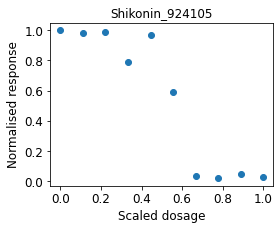

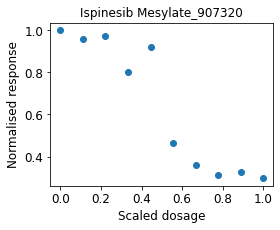

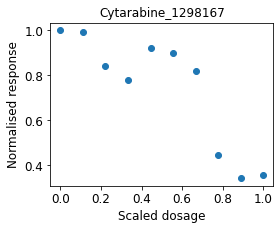

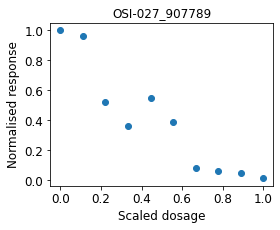

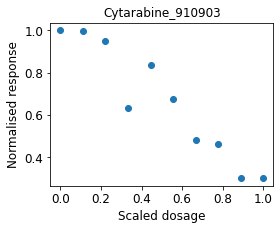

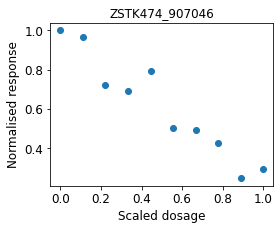

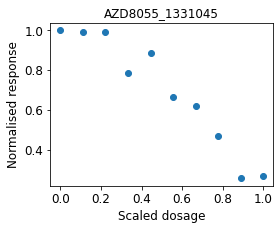

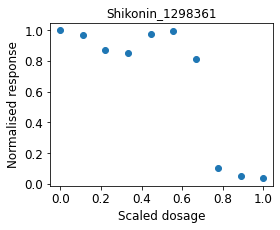

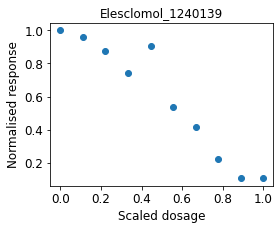

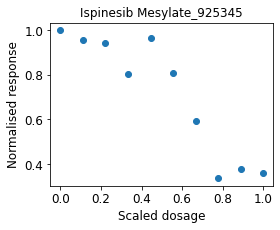

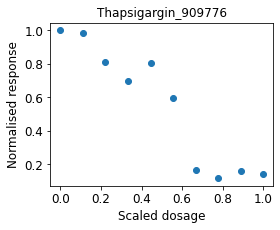

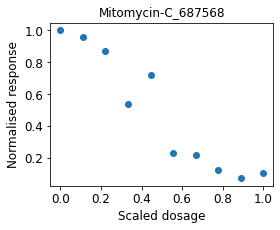

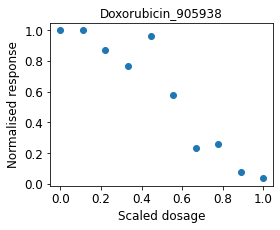

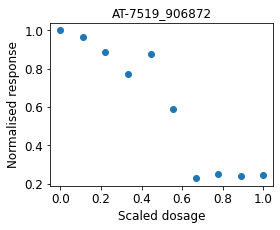

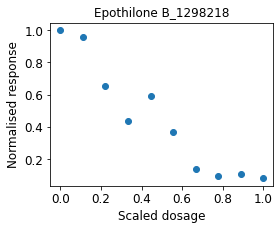

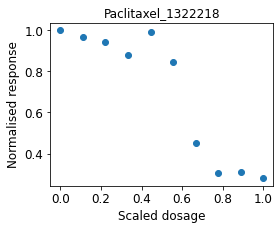

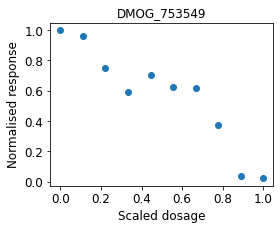

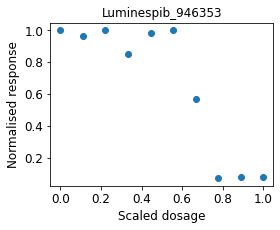

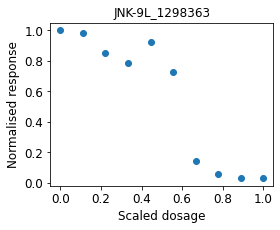

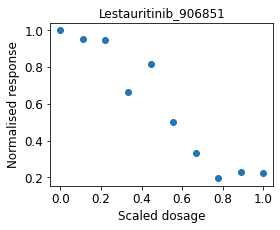

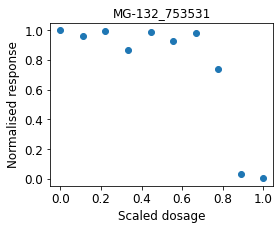

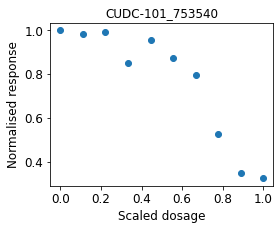

In [24]:
# difference between setting limit 0.2 and 0.1

ind_02_01 = set(df_11.index)- set(df_22.index)
len(ind_02_01)

for i, ind in enumerate(ind_02_01):
    plt.figure(i)
    drug_id = df_11.loc[ind, "DRUG_ID"]
    cosmic_id = df_11.loc[ind, "COSMIC_ID"]
    show_one(df, drug_id, cosmic_id, save_name =drug_names[drug_id]+"-"+str(cosmic_id))

/home/marina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

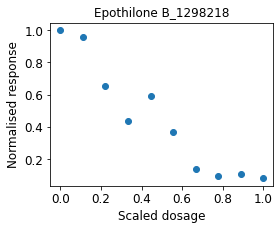

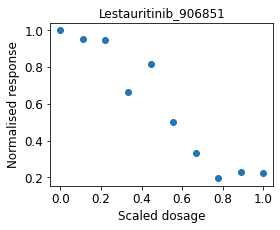

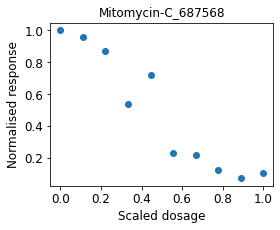

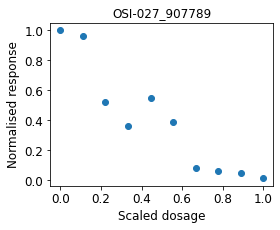

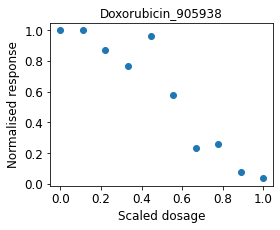

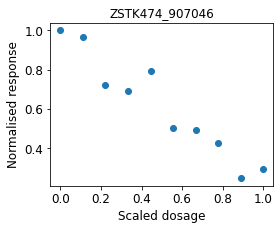

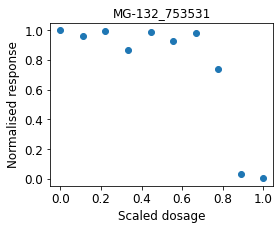

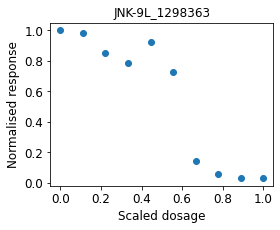

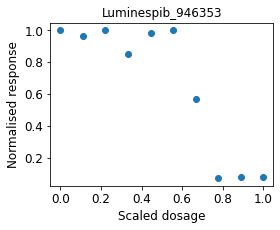

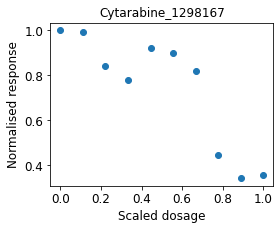

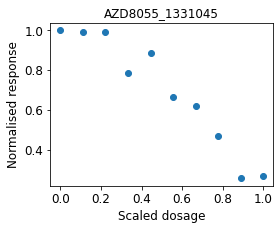

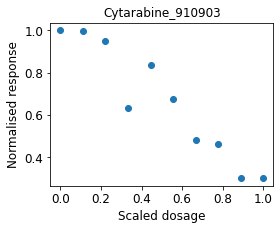

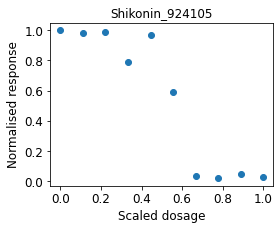

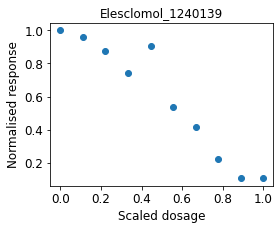

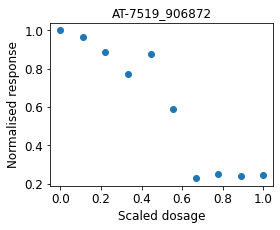

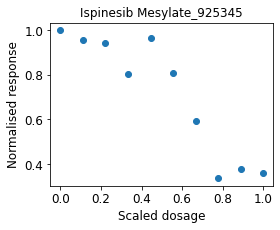

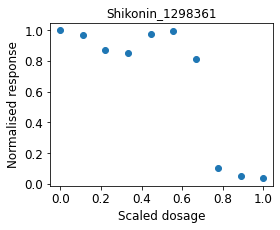

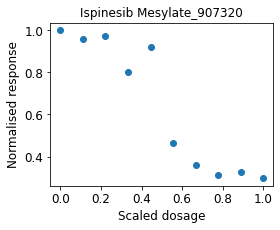

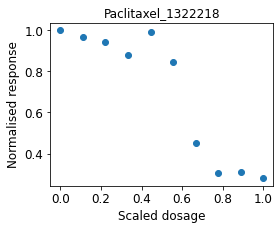

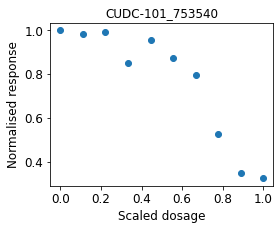

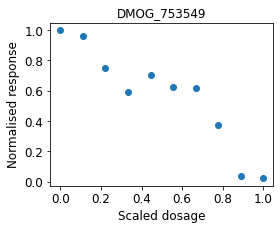

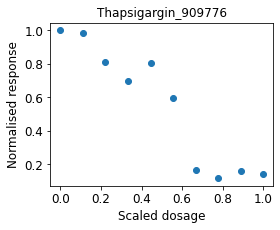

In [25]:
for i, ind in enumerate(df_11.index):
    plt.figure(i)
    drug_id = df_11.loc[ind, "DRUG_ID"]
    cosmic_id = df_11.loc[ind, "COSMIC_ID"]
    show_one(df, drug_id, cosmic_id)

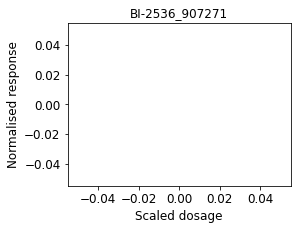

In [26]:
drug_id = 60
cosmic_id = 907271
show_one(df, drug_id, cosmic_id)

### Do we need 2d filtering criteria about first and last points forming plateus?

In [27]:
df3 = FilteringCurves(drug_curves, filtering_scenario=[1,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 44)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 44)


DRUG_ID: 302, COSMIC_ID: 722066, Drug Name: PI-103, CCL: NCI-H650


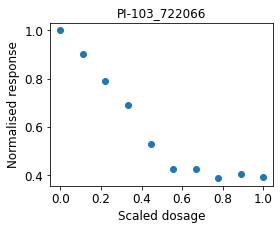

In [28]:
# filtering_scenario=[1,3,4] - why we need restriction for plateus
ind = 131086
drug_id = df3.loc[ind, "DRUG_ID"]
cosmic_id = df3.loc[ind, "COSMIC_ID"]
print("DRUG_ID: {}, COSMIC_ID: {}, Drug Name: {}, CCL: {}".format(drug_id, cosmic_id, drug_names[drug_id], CLL_names[cosmic_id]))
show_one(df3, drug_id, cosmic_id)

DRUG_ID: 276, COSMIC_ID: 1480374, Drug Name: CAY10603, CCL: UWB1.289


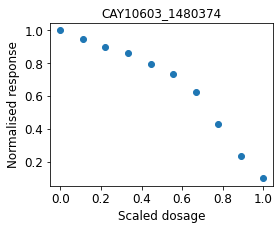

In [29]:
# filtering_scenario=[1,3,4] - why we need restriction for plateus
ind = 131087
drug_id = df3.loc[ind, "DRUG_ID"]
cosmic_id = df3.loc[ind, "COSMIC_ID"]
print("DRUG_ID: {}, COSMIC_ID: {}, Drug Name: {}, CCL: {}".format(drug_id, cosmic_id, drug_names[drug_id], CLL_names[cosmic_id]))
show_one(df3, drug_id, cosmic_id)

In [30]:
# extracting sigmoid forms - adding restriction for plateus
df3_1 = FilteringCurves(df3, filtering_scenario=[2], \
                        response_columns = response_norm, tolerance=0.05,
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)

Original dataset: (16488, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (2600, 46)


In [31]:
df3.shape[0], df3_1.shape[0]

(16488, 2600)

In [32]:
drug_id = 180
cosmic_id = 909730
df3[(df3["DRUG_ID"]==drug_id) & (df3["COSMIC_ID"]==cosmic_id)][["norm_cells_"+str(i) for i in range(10)]].T

131101
norm_cells_0  1.000000
norm_cells_1  0.922945
norm_cells_2  0.867442
norm_cells_3  0.785392
norm_cells_4  0.501900
norm_cells_5  0.241226
norm_cells_6  0.092333
norm_cells_7  0.074661
norm_cells_8  0.063998
norm_cells_9  0.062790

In [33]:
1.000 - 0.922945

0.07705499999999998

In [34]:
# linear forms: 
lin_ind = set(df3.index)- set(df3_1.index)
df3_2 = df3.loc[lin_ind, :]
print("Sigmoid shape:", df3_1.shape[0])
print("Linear ? shape:", df3_2.shape[0])

Sigmoid shape: 2600
Linear ? shape: 13888


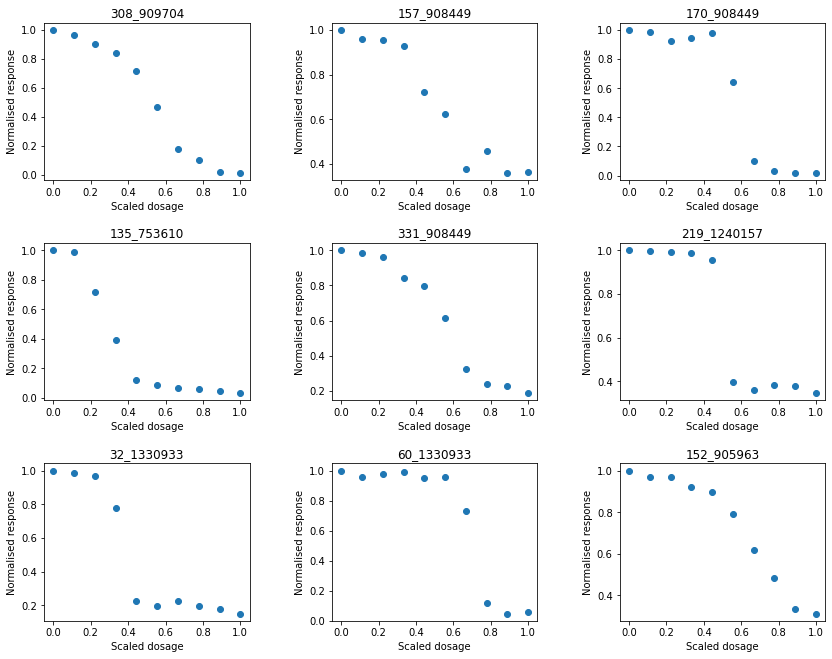

In [35]:
ShowResponseCurves(df3_1, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df3_1.index[:9])

In [36]:
drug_id = 157
cosmic_id = 908449
df[(df["DRUG_ID"]==drug_id) & (df["COSMIC_ID"]==cosmic_id)][["norm_cells_"+str(i) for i in range(10)]].T

60
norm_cells_0  1.000000
norm_cells_1  0.958112
norm_cells_2  0.953868
norm_cells_3  0.926033
norm_cells_4  0.720981
norm_cells_5  0.622026
norm_cells_6  0.378269
norm_cells_7  0.457085
norm_cells_8  0.358507
norm_cells_9  0.362443

In [37]:
0.378269-0.457085

-0.078816

In [38]:
#df3_1.to_csv(_FOLDER_3+"sigmoid.csv")

In [39]:
df3_2.head(10)

Unnamed: 0 CELL_LINE_NAME  COSMIC_ID  DRUG_ID DRUGID_COSMICID  \
65543        65543       NCI-H196    1240186      294     294_1240186   
131086      131086       NCI-H650     722066      302      302_722066   
131087      131087       UWB1.289    1480374      276     276_1480374   
22              22         HDQ-P1    1290922      272     272_1290922   
131096      131096          RD-ES    1330996      228     228_1330996   
65560        65560            HEL     907053      223      223_907053   
131100      131100          IM-95    1240155      283     283_1240155   
131101      131101       SK-NEP-1     909730      180      180_909730   
65567        65567           KP-3    1298219      182     182_1298219   
65574        65574            HEL     907053      261      261_907053   

        FOLD_DILUTION  MAX_CONC  fd_num_0  fd_num_1  fd_num_2  ...  \
65543               2    20.000         0  0.111111  0.222222  ...   
131086              2    10.240         0  0.111111  0.222222  ...   
131087              2    20.000         0  0.111111  0.222222  ...   
22                  2     5.120         0  0.111111  0.222222  ...   
131096              2    10.240         0  0.111111  0.222222  ...   
65560               2     5.120         0  0.111111  0.222222  ...   
131100              2     0.128         0  0.111111  0.222222  ...   
131101              2     0.512         0  0.111111  0.222222  ...   
65567               2    16.000         0  0.111111  0.222222  ...   
65574               2    10.240         0  0.111111  0.222222  ...   

        per_slope_change_7   slope_0   slope_1   slope_2   slope_3   slope_4  \
65543              -104.96 -1.232139 -0.196699  0.645572 -0.055981  0.055410   
131086            -1.70696 -0.872783 -1.015732 -0.882676 -1.448519 -0.956395   
131087           -0.307916 -0.497667 -0.398883 -0.358493 -0.595594 -0.562887   
22               -0.709786 -1.428897 -0.442275 -1.256773 -0.460310  0.172309   
131096             5.34047 -1.064777 -0.280937  0.213673 -0.253518 -0.548294   
65560              4.25737 -0.872616 -0.270015 -0.195266 -0.600387 -0.317749   
131100            -3.74099 -1.464007 -1.327485 -1.248016  0.205013 -1.228511   
131101           -0.886804 -0.693494 -0.499530 -0.738443 -2.551430 -2.346065   
65567            -0.892455 -1.112600  0.138911 -3.117547 -1.813912 -1.693795   
65574             -12.9158 -1.629769  0.792801 -0.732069 -0.162283  0.310668   

         slope_5   slope_6   slope_7   slope_8  
65543   0.151823  0.172426  0.051645 -5.369003  
131086  0.026700 -0.361916  0.149375 -0.105602  
131087 -0.945100 -1.752392 -1.772269 -1.226560  
22     -1.150468 -1.248002 -1.398412 -0.405838  
131096 -1.113210 -1.080428 -0.544200 -3.450489  
65560  -0.817999 -0.673445 -0.651637 -3.425899  
131100 -0.462302 -0.451986  0.020838 -0.057116  
131101 -1.340036 -0.159050 -0.095973 -0.010864  
65567   0.406397 -0.273261 -1.323751 -0.142362  
65574   0.284373 -0.175568  0.474879 -5.658565  

[10 rows x 44 columns]

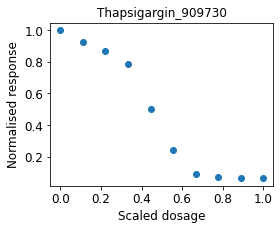

In [40]:
# ind = 131101
# drug_id = df3.loc[ind, "DRUG_ID"]
# cosmic_id = df3.loc[ind, "COSMIC_ID"]

drug_id = 180
cosmic_id = 909730
show_one(df3_2, drug_id, cosmic_id)

In [41]:
drug_id = 180
cosmic_id = 909730
df3[(df3["DRUG_ID"]==drug_id) & (df3["COSMIC_ID"]==cosmic_id)][["norm_cells_"+str(i) for i in range(10)]].T

131101
norm_cells_0  1.000000
norm_cells_1  0.922945
norm_cells_2  0.867442
norm_cells_3  0.785392
norm_cells_4  0.501900
norm_cells_5  0.241226
norm_cells_6  0.092333
norm_cells_7  0.074661
norm_cells_8  0.063998
norm_cells_9  0.062790

### Labelling

In [43]:
df = drug_curves.copy()
df2 = drug_curves.copy()
indexes= {}
for i in [1,3,4,2]:
    df = FilteringCurves(df, filtering_scenario=[i], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)
    indexes[i] = df.index
    df2.loc[df.index,"filt_"+str(i)]=1

df2.fillna(0, inplace=True)

df2["sum"] = df2[["filt_"+str(i) for i in range(1,5)]].sum(axis=1)
df2["sum"].value_counts() 

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
Original dataset: (63325, 44)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 44)
Original dataset: (19037, 44)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 44)
Original dataset: (16488, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (2600, 46)


0.0    162059
1.0     44288
3.0     13888
4.0      2600
2.0      2549
Name: sum, dtype: int64

### Filtering scenario 1+2+3

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)


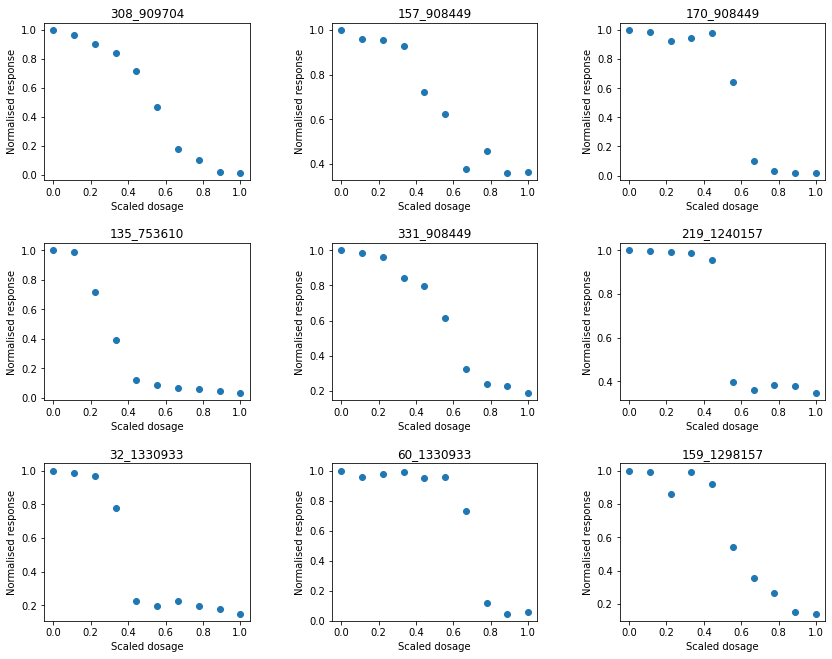

In [44]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 46)


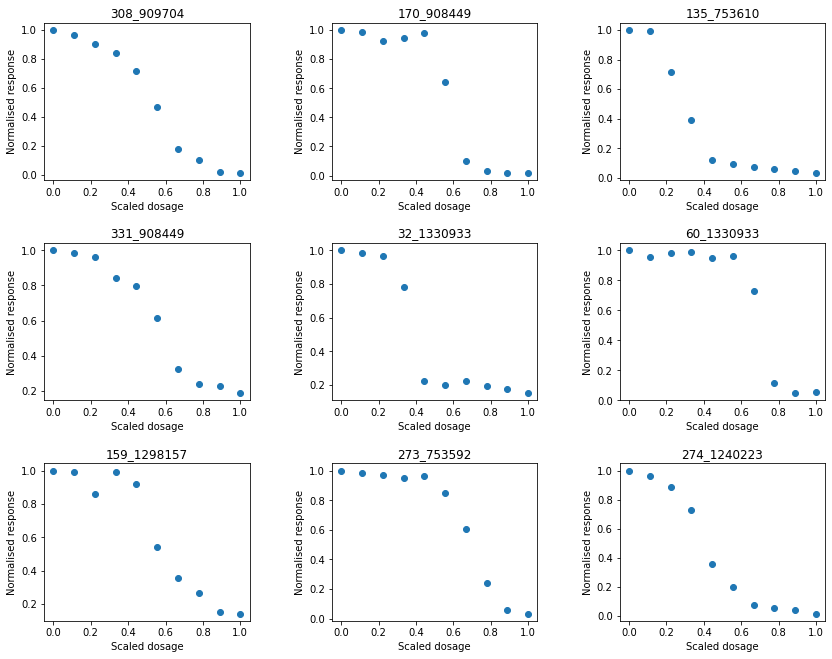

In [45]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

### Filtering scenario 1+2+3+4

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2600, 46)


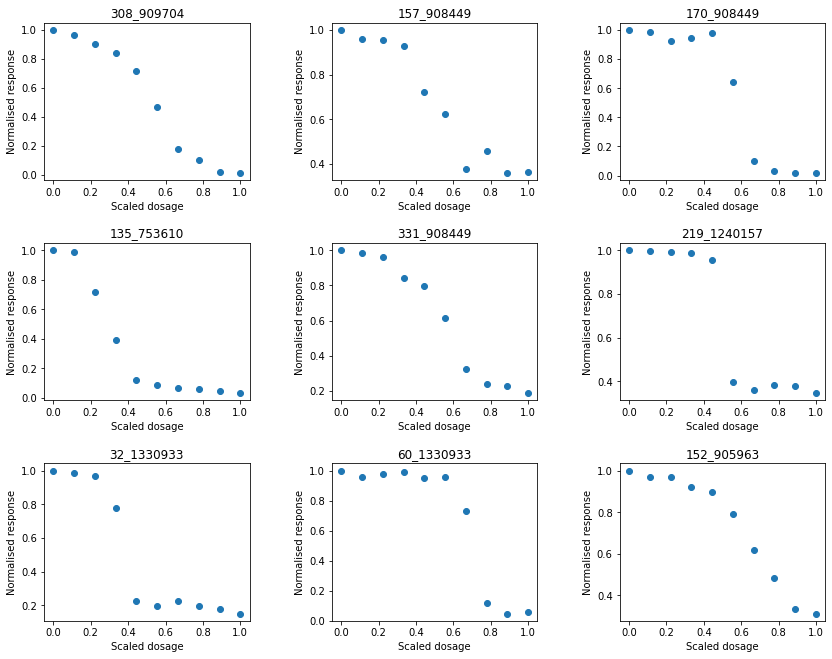

In [50]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4,
                    middle_points_limit = -0.1)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2037, 46)


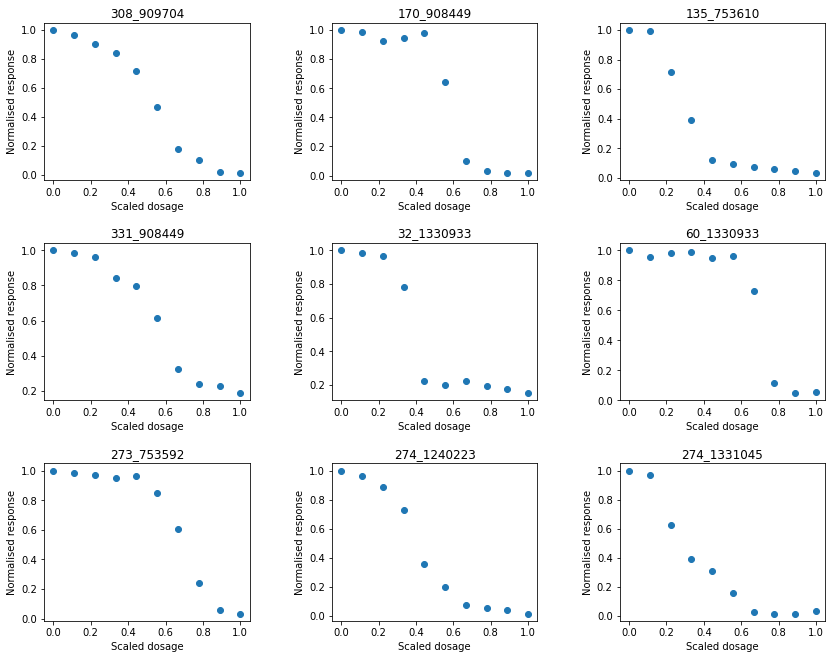

In [51]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2,
                    middle_points_limit = -0.1)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

### Filtering scenario 1+3+4

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 44)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 44)


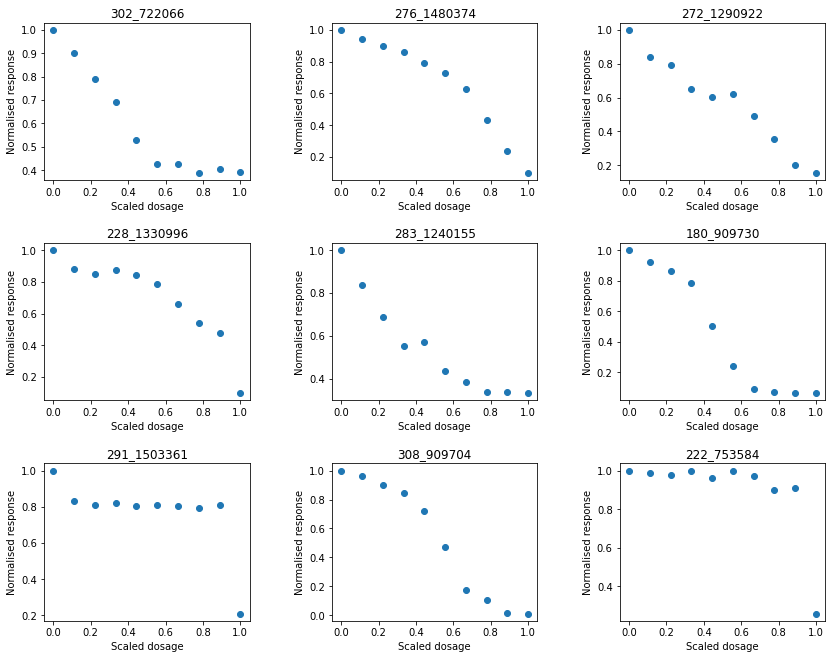

In [49]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

### Figures for the report - final data

In [ ]:
plt.figure(figsize=(4,3))
# ind = df[(df["DRUG_ID"]==274) &(df["COSMIC_ID"]==1240223)].index
ind = df[(df["DRUG_ID"]==219) &(df["COSMIC_ID"]==1240157)].index
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=12)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt3.png", bbox_inches='tight', dpi=360)